In [5]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [6]:
#Json data from Poloniex exchange

def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [7]:
#Download data
altcoins = ['ETH','ETC','LTC','XRP','ETC','XMR','ZEC','BCH','LSK','ZRX','GNT','OMG','GAS','REP','CVC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1483225200.0&end=1508431052.345257&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ZEC&start=1483225200.0&end=1508431052.345257&period=86

In [8]:
altcoin_data['ETH'].head()


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2017-01-01,0.008200,0.008931,0.008001,0.008335,7.046517e+05,5968.975870,0.008471
2017-01-02,0.008220,0.008434,0.007823,0.008199,6.372636e+05,5162.784640,0.008101
2017-01-03,0.009280,0.009750,0.008033,0.008218,1.376059e+06,12499.794908,0.009084
2017-01-04,0.009745,0.010099,0.009000,0.009288,1.539592e+06,14953.471931,0.009713
2017-01-05,0.010185,0.010448,0.009251,0.009745,1.531161e+06,15295.670614,0.009990


In [9]:
len(altcoin_data['LTC'])

292

In [10]:
# plotly user defined function
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [11]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)


In [12]:
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'weightedAverage')


In [22]:

# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (BTC)', seperate_y_axis=False, y_axis_label='Coin Value (BTC)')

In [24]:
# Chart all of the altocoin prices - log scale
df_scatter(combined_df, 'Cryptocurrency Prices (BTC)', seperate_y_axis=False, y_axis_label='Coin Value (BTC)', scale='log')

In [29]:
# Calculate Mean Price as a new column in combined data frame
df_new = combined_df.fillna(0) #Nan to Zero

df_new['mean'] = df_new.mean(axis=1) #mean along rows


In [84]:

#Mean-scaled price for each coin
for altcoin in altcoin_data.keys():
    df_new[altcoin] = df_new[altcoin]/df_new['mean']
    print(df_new[altcoin])

date
2017-01-01    1.455393
2017-01-02    1.387491
2017-01-03    1.526094
2017-01-04    1.617156
2017-01-05    1.628395
2017-01-06    1.712391
2017-01-07    1.743885
2017-01-08    1.763721
2017-01-09    1.839839
2017-01-10    1.835096
2017-01-11    1.890714
2017-01-12    1.830834
2017-01-13    1.803819
2017-01-14    1.825099
2017-01-15    1.855169
2017-01-16    1.827239
2017-01-17    1.852231
2017-01-18    1.898899
2017-01-19    1.902251
2017-01-20    1.954320
2017-01-21    1.965994
2017-01-22    1.969322
2017-01-23    1.978171
2017-01-24    2.005631
2017-01-25    2.032008
2017-01-26    2.062178
2017-01-27    2.074718
2017-01-28    2.068080
2017-01-29    2.036512
2017-01-30    2.054585
                ...   
2017-09-20    3.384577
2017-09-21    3.456467
2017-09-22    3.449962
2017-09-23    3.485987
2017-09-24    3.590485
2017-09-25    3.485100
2017-09-26    3.412529
2017-09-27    3.306716
2017-09-28    3.167540
2017-09-29    3.281708
2017-09-30    3.352109
2017-10-01    3.425686
2017-1

In [85]:
df_new.head()

,BCH,CVC,ETC,ETH,GAS,GNT,LSK,LTC,OMG,REP,XMR,XRP,ZEC,ZRX,mean
date,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.248165,1.455393,0.0,0.0,0.026993,0.774975,0.0,0.664023,2.369337,0.001125,8.459989,0.0,0.005820
2017-01-02,0.0,0.0,0.237678,1.387491,0.0,0.0,0.026095,0.773450,0.0,0.684069,2.581090,0.001060,8.309065,0.0,0.005839
2017-01-03,0.0,0.0,0.245608,1.526094,0.0,0.0,0.025467,0.747959,0.0,0.696659,2.640265,0.001047,8.116900,0.0,0.005952
2017-01-04,0.0,0.0,0.247713,1.617156,0.0,0.0,0.025794,0.693435,0.0,0.717379,2.612029,0.000997,8.085497,0.0,0.006006
2017-01-05,0.0,0.0,0.256841,1.628395,0.0,0.0,0.025041,0.705384,0.0,0.748852,2.608714,0.000952,8.025821,0.0,0.006135


In [30]:

for altcoin in altcoin_data.keys():
    df_new[altcoin] = df_new[altcoin]/df_new['mean']
    
df_new.head();

In [86]:
# Chart all of the altocoin prices - log scale
df_scatter(df_new, 'Cryptocurrency Prices (BTC)', seperate_y_axis=False, y_axis_label='Coin Value (BTC)')

In [90]:
np.corrcoef(df_new)

array([[ 1.        ,  0.99952506,  0.99897354, ...,  0.43433818,
         0.43806048,  0.44549373],
       [ 0.99952506,  1.        ,  0.99971132, ...,  0.42964693,
         0.43328185,  0.44070304],
       [ 0.99897354,  0.99971132,  1.        , ...,  0.43884287,
         0.44251651,  0.45026849],
       ..., 
       [ 0.43433818,  0.42964693,  0.43884287, ...,  1.        ,
         0.99997301,  0.99953348],
       [ 0.43806048,  0.43328185,  0.44251651, ...,  0.99997301,
         1.        ,  0.99970533],
       [ 0.44549373,  0.44070304,  0.45026849, ...,  0.99953348,
         0.99970533,  1.        ]])

In [97]:
def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [31]:
df_corr = df_new.pct_change().corr(method='pearson')

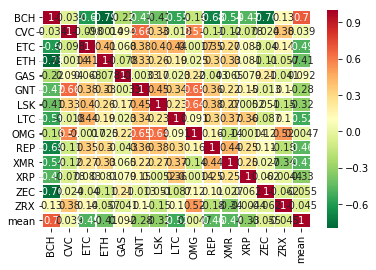

In [32]:
import seaborn as sns
%matplotlib inline

#idx= altcoin_list.keys()
#cols = list(altcoin_list.keys())
#df = DataFrame(abs(np.random.randn(5,4)), index=idx, columns=cols)

# _r reverses the normal order of the color map 'RdYlGn'
sns.heatmap(df_corr, cmap='RdYlGn_r', linewidths=0.5, annot=True)

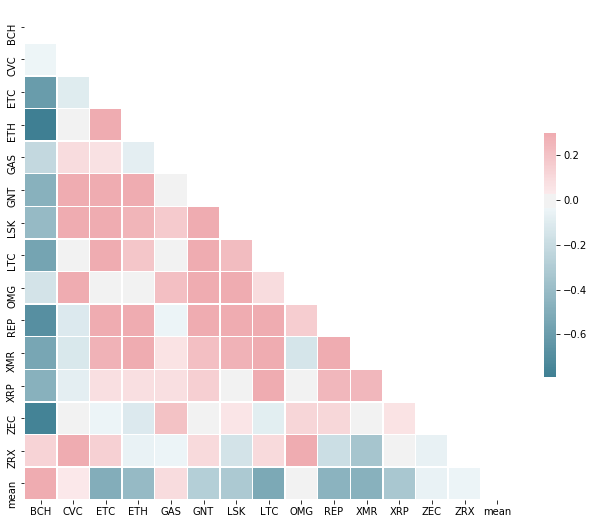

In [33]:
import matplotlib.pyplot as plt
corr = df_corr
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})